In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss

from transformers import (
  AutoTokenizer, 
  AutoModelForSequenceClassification, 
  Trainer, 
  TrainingArguments,
  DataCollatorWithPadding
)

from datasets import Dataset, DatasetDict
from sklearn.metrics import (
  accuracy_score,
  f1_score,
  precision_score,
  recall_score,
  confusion_matrix,
  classification_report
  )
import os
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
processed_df = joblib.load("../../data/processed/processed_ISEC_train_df.joblib")
processed_df

,Text,Component,Status,Resolution,Priority
0,font size 9px rounded down to 8px {font} {ll} ...,Layout,VERIFIED,FIXED,0
1,Land OOP plugins in mozilla-central (preffed o...,Plug-ins,RESOLVED,FIXED,0
2,XP-COM Proxy code crashes when trying to AutoP...,XPCOM,VERIFIED,FIXED,0
3,crash setting display:none on grid rows [@ nsG...,XUL,VERIFIED,FIXED,0
4,limit the memory cache to a reasonable value I...,Networking,VERIFIED,FIXED,0
...,...,...,...,...,...
52989,Replicate functionality (1GGP770) In regular u...,Team,RESOLVED,WONTFIX,4
52990,[charset]Improve @charset parsing in CSSLoader...,CSS,RESOLVED,FIXED,4
52991,iCab Profile Migrator .,Other,RESOLVED,WONTFIX,4
52992,The tableSectionElement.ch doesnt have a defau...,DOM,VERIFIED,FIXED,4


In [4]:
processed_df["Text"] = (
  "[META] Component: " + processed_df["Component"] + " | " +
  "[META] Status: " + processed_df["Status"] + " | " +
  "[META] Resolution: " + processed_df["Resolution"] + " | " +
  "[DESC] " + processed_df["Text"]
)

In [5]:
processed_df = processed_df[["Text", "Priority"]].copy()
processed_df = processed_df.dropna(subset=["Text", "Priority"])

In [6]:
processed_df

,Text,Priority
0,[META] Component: Layout | [META] Status: VERI...,0
1,[META] Component: Plug-ins | [META] Status: RE...,0
2,[META] Component: XPCOM | [META] Status: VERIF...,0
3,[META] Component: XUL | [META] Status: VERIFIE...,0
4,[META] Component: Networking | [META] Status: ...,0
...,...,...
52989,[META] Component: Team | [META] Status: RESOLV...,4
52990,[META] Component: CSS | [META] Status: RESOLVE...,4
52991,[META] Component: Other | [META] Status: RESOL...,4
52992,[META] Component: DOM | [META] Status: VERIFIE...,4


In [7]:
processed_df["label"] = processed_df["Priority"].astype(int)

In [8]:
num_labels = processed_df["label"].nunique()
print(f"Num labels: {num_labels}, classes: {sorted(processed_df['label'].unique())}")

Num labels: 5, classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [9]:
label_map = {i: label for i, label in enumerate(sorted(processed_df["label"].unique()))}
print("Label map: ", label_map)

Label map:  {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4)}


In [10]:
train_df, val_df = train_test_split(
  processed_df,
  test_size=0.1,
  random_state=42,
  stratify=processed_df["label"]
)

print("Train shape: ", train_df.shape)
print("Validation shape: ", val_df.shape)

Train shape:  (47490, 3)
Validation shape:  (5277, 3)


In [11]:
dataset_train = Dataset.from_pandas(train_df.reset_index(drop=True))
dataset_val = Dataset.from_pandas(val_df.reset_index(drop=True))
ds = DatasetDict({"train": dataset_train, "validation": dataset_val})

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [13]:
def tokenize_fn(batch):
  tokens = tokenizer(batch["Text"], truncation=True, max_length=296)
  tokens["labels"] = batch["label"]
  return tokens

In [14]:
ds = ds.map(tokenize_fn, batched=True, remove_columns=["Text", "Priority", "label"], keep_in_memory=True)

Map:   0%|          | 0/47490 [00:00<?, ? examples/s]

Map:   0%|          | 0/5277 [00:00<?, ? examples/s]

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
y_train = train_df["label"].values
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights: ", class_weights)

Class weights:  tensor([1.1803, 1.1220, 0.3411, 4.6174, 8.8601], device='cuda:0')


In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
  "bert-base-cased",
  num_labels=num_labels
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
class WeightedTrainer(Trainer):
  def __init__(self, *args, class_weights=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None
    
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.get("labels")
    outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=self.class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [19]:
def compute_metric(pred):
  logits = pred.predictions
  preds = np.argmax(logits, axis=-1)
  labels = pred.label_ids
  
  accuracy = accuracy_score(labels, preds)
  precision_macro = precision_score(labels, preds, average="macro", zero_division=0)
  recall_macro = recall_score(labels, preds, average="macro", zero_division=0)
  f1_macro = f1_score(labels, preds, average="macro")
  
  return {
    "accuracy": accuracy,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro,
    "f1_macro": f1_macro
  }

In [20]:
# Define training arguments
training_args = TrainingArguments(
  output_dir="../models/bert",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  learning_rate=2e-5,
  num_train_epochs=4,
  eval_strategy="epoch",
  save_strategy="epoch",
  logging_dir="../models/bert/logs/",
  logging_steps=100,
  weight_decay=0.01,
  load_best_model_at_end=True,
  metric_for_best_model="f1_macro",
  fp16=True
)

In [21]:
trainer = WeightedTrainer(
  model=model,
  args=training_args,
  train_dataset=ds["train"],
  eval_dataset=ds["validation"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metric,
  class_weights=class_weights
)

C:\Users\rusty\AppData\Local\Temp\ipykernel_18756\1673886968.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.435700,1.416172,0.533637,0.351844,0.398402,0.338598
2,1.330000,1.356333,0.554292,0.425553,0.423791,0.402423
3,1.217300,1.372447,0.584802,0.415067,0.443360,0.421674
4,0.983500,1.447479,0.573621,0.404034,0.447360,0.414707


TrainOutput(global_step=11876, training_loss=1.2829767473220184, metrics={'train_runtime': 4861.7576, 'train_samples_per_second': 39.072, 'train_steps_per_second': 2.443, 'total_flos': 2.8875722734404468e+16, 'train_loss': 1.2829767473220184, 'epoch': 4.0})

In [23]:
trainer.evaluate()

{'eval_loss': 1.3724467754364014,
 'eval_accuracy': 0.5848019708167519,
 'eval_precision_macro': 0.4150666918545503,
 'eval_recall_macro': 0.4433596903968152,
 'eval_f1_macro': 0.4216741386131185,
 'eval_runtime': 34.9626,
 'eval_samples_per_second': 150.933,
 'eval_steps_per_second': 9.439,
 'epoch': 4.0}

C:\Users\rusty\AppData\Local\Temp\ipykernel_18756\3224661968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


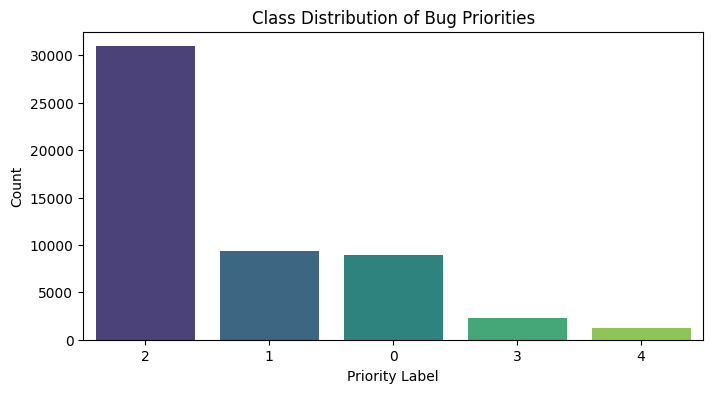

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(
  x="Priority",
  data=processed_df,
  order=processed_df["Priority"].value_counts().index,
  palette="viridis"
)

plt.title("Class Distribution of Bug Priorities")
plt.xlabel("Priority Label")
plt.ylabel("Count")
plt.show()

In [25]:
class_counts = processed_df["Priority"].value_counts()
class_proportions = class_counts / len(processed_df)
print("Class proportions: ", class_proportions)

Class proportions:  Priority
2    0.586427
1    0.178236
0    0.169443
3    0.043323
4    0.022571
Name: count, dtype: float64


In [26]:
predictions = trainer.predict(ds["validation"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

In [28]:
labels = sorted(processed_df["Priority"].unique())
cm = confusion_matrix(y_true, y_pred)

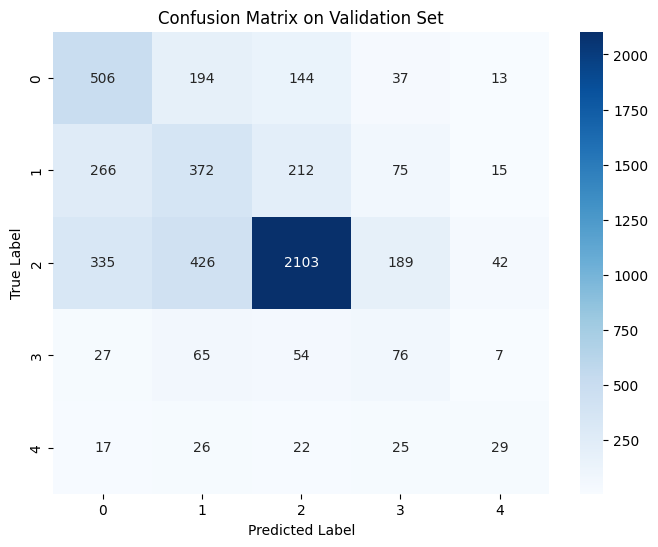

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(
  cm,
  annot=True,
  fmt="d",
  cmap="Blues",
  xticklabels=labels,
  yticklabels=labels
)

plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
cm

array([[ 506,  194,  144,   37,   13],
       [ 266,  372,  212,   75,   15],
       [ 335,  426, 2103,  189,   42],
       [  27,   65,   54,   76,    7],
       [  17,   26,   22,   25,   29]])

In [31]:
label_names = [str(l) for l in labels]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.440     0.566     0.495       894
           1      0.343     0.396     0.368       940
           2      0.830     0.679     0.747      3095
           3      0.189     0.332     0.241       229
           4      0.274     0.244     0.258       119

    accuracy                          0.585      5277
   macro avg      0.415     0.443     0.422      5277
weighted avg      0.637     0.585     0.604      5277



In [32]:
trainer.save_model("../models/bert")
tokenizer.save_pretrained("../models/bert")

('../models/bert\\tokenizer_config.json',
 '../models/bert\\special_tokens_map.json',
 '../models/bert\\vocab.txt',
 '../models/bert\\added_tokens.json',
 '../models/bert\\tokenizer.json')

In [34]:
label_map_path = os.path.join("../models/bert", "label_map.json")
label_map_serializable = {int(k): int(v) for k, v in label_map.items()}
with open(label_map_path, "w") as f:
  json.dump(label_map_serializable, f)
  
print("Saved model + tokenizer + label_map")

Saved model + tokenizer + label_map


In [35]:
test_df = pd.read_csv("../../data/raw/test.csv")

In [46]:
test_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Text
0,6578,JavaScript Engine,Finalize yield syntax to match ES4/JS2 proposal,This tracks Python 2.5. Currently we allow; ;...,VERIFIED,FIXED,Finalize yield syntax to match ES4/JS2 proposa...
1,8050,Networking: Cache,e10s HTTP: offline application cache,I actually know very little about how applicat...,RESOLVED,FIXED,e10s HTTP: offline application cache I actuall...
2,5281,DOM: Core & HTML,[FIX]Add GetOwnerDocument on nsIContent or nsG...,See comments in bug 211440; the idea is to add...,RESOLVED,FIXED,[FIX]Add GetOwnerDocument on nsIContent or nsG...
3,7871,Layout: View Rendering,Text editing broken in Firebug edit mode and o...,Getting reports that editing is broken in Fire...,VERIFIED,FIXED,Text editing broken in Firebug edit mode and o...
4,2411,Plug-ins,shockwave movies redraw improperly on mac(nsbe...,From Bugzilla Helper:; User-Agent: Mozilla/4.7...,VERIFIED,DUPLICATE,shockwave movies redraw improperly on mac(nsbe...


In [37]:
test_df["Text"]  = test_df["Title"].fillna("") + " " + test_df["Description"].fillna("")

In [39]:
tokenizer = AutoTokenizer.from_pretrained("../models/bert")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [40]:
with open("../models/bert/label_map.json", "r") as f:
  label_map = json.load(f)

label_map = {int(k): v for k, v in label_map.items()}

In [48]:
batch_size = 16
all_preds = []

for i in range(0, len(test_df), batch_size):
  batch_texts = test_df["Text"].iloc[i:i + batch_size].tolist()
  
  inputs = tokenizer(
    batch_texts,
    truncation=True,
    max_length=296,
    padding=True,
    return_tensors="pt"
  )

  inputs = {k: v.to(device) for k, v in inputs.items()}
  
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1).cpu().numpy()
    all_preds.extend(preds)
  
test_df["Predicted_Priority"] = [label_map[i] for i in all_preds]

In [50]:
test_df.to_csv("../../data/processed/text_predictions.csv", index=False)